In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['training.1600000.processed.noemoticon.csv']


In [2]:
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

In [3]:
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
data = pd.read_csv('../input/training.1600000.processed.noemoticon.csv', encoding =DATASET_ENCODING , names=DATASET_COLUMNS)
data.head()
X = data.iloc[:,[5]]
Y = data.iloc[:,0]
Y[Y == 4] = 1

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [4]:
data.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [5]:
# Text-preprocessing

# Missing Values
num_missing_desc = data.isnull().sum()[2]    # No. of values with msising descriptions
print('Number of missing values: ' + str(num_missing_desc))
data = data.dropna()

TAG_CLEANING_RE = "@\S+"
# Remove @tags
X['text'] = X['text'].map(lambda x: re.sub(TAG_CLEANING_RE, ' ', x))

# Smart lowercase
X['text'] = X['text'].map(lambda x: x.lower())

# Remove numbers
X['text'] = X['text'].map(lambda x: re.sub(r'\d+', ' ', x))

# Remove links
TEXT_CLEANING_RE = "https?:\S+|http?:\S|[^A-Za-z0-9]+"
X['text'] = X['text'].map(lambda x: re.sub(TEXT_CLEANING_RE, ' ', x))

# Remove Punctuation
X['text']  = X['text'].map(lambda x: x.translate(x.maketrans('', '', string.punctuation)))

# Remove white spaces
X['text'] = X['text'].map(lambda x: x.strip())

# Tokenize into words
X['text'] = X['text'].map(lambda x: word_tokenize(x))
 
# Remove non alphabetic tokens
X['text'] = X['text'].map(lambda x: [word for word in x if word.isalpha()])

# Filter out stop words
stop_words = set(stopwords.words('english'))
X['text'] = X['text'].map(lambda x: [w for w in x if not w in stop_words])
    
# Word Lemmatization
lem = WordNetLemmatizer()
X['text'] = X['text'].map(lambda x: [lem.lemmatize(word,"v") for word in x])

# Turn lists back to string
X['text'] = X['text'].map(lambda x: ' '.join(x))

Number of missing values: 0


In [6]:
X.head()

,text
0,zl awww bummer shoulda get david carr third day
1,upset update facebook texting might cry result...
2,dive many time ball manage save rest go bound
3,whole body feel itchy like fire
4,behave mad see


In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print("TRAIN size:", len(X_train))
print("TEST size:", len(X_train))

TRAIN size: 1280000
TEST size: 1280000


In [8]:
# Word2Vec
import gensim

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

documents = [_text.split() for _text in X_train.text] 
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)
w2v_model.build_vocab(documents)

/opt/conda/lib/python3.6/site-packages/smart_open/ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')


In [9]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 25276


In [10]:
# Train Word Embeddings
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

(251368450, 289225504)

In [11]:
#Test word embeddings
w2v_model.most_similar("great")

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  


[('fantastic', 0.7246146202087402),
 ('wonderful', 0.7117769718170166),
 ('good', 0.6914220452308655),
 ('awesome', 0.6730504035949707),
 ('amaze', 0.6271382570266724),
 ('fab', 0.608104407787323),
 ('excellent', 0.5928096771240234),
 ('fabulous', 0.5905833840370178),
 ('nice', 0.5762463808059692),
 ('enjoy', 0.5472447872161865)]

In [12]:
# Tokenizing
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout
from keras.utils.np_utils import to_categorical

# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 300
# This is fixed.
EMBEDDING_DIM = 300

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train.text)
word_index = tokenizer.word_index
vocab_size = len(word_index)
print('Found %s unique tokens.' % len(word_index))

# Convert the data to padded sequences
X_train_padded = tokenizer.texts_to_sequences(X_train.text)
X_train_padded = pad_sequences(X_train_padded, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X_train_padded.shape)

# Save the tokenizer
with open('/kaggle/working/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Save the MAX_SEQUENCE_LENGTH
with open('/kaggle/working/max_sequence_length.txt', 'w') as f:
    f.write(str(MAX_SEQUENCE_LENGTH))

Using TensorFlow backend.


Found 232838 unique tokens.
Shape of data tensor: (1280000, 300)


In [13]:
# Embedding matrix for the embedding layer
embedding_matrix = np.zeros((vocab_size+1, W2V_SIZE))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(232839, 300)


In [14]:
# Build Model
from keras.layers import Conv1D, GlobalMaxPooling1D
import keras 

model = Sequential()
model.add(Embedding(vocab_size+1, W2V_SIZE, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False))
model.add(Dropout(0.3))
model.add(Conv1D(300,3,activation='relu'))
# we use max pooling:
model.add(GlobalMaxPooling1D())
model.add(Dense(200, activation='sigmoid'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 300)          69851700  
_________________________________________________________________
dropout_1 (Dropout)          (None, 300, 300)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 298, 300)          270300    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 300)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               60200     
_________________________________________________________________
dropout_2 (Dropout)  

In [15]:
# Training 
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

BATCH_SIZE = 1024
history = model.fit(X_train_padded, y_train,
                    batch_size=512,
                    epochs=5,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 1152000 samples, validate on 128000 samples
Epoch 1/5
1152000/1152000 [==============================] - 122s 106us/step - loss: 0.4931 - acc: 0.7584 - val_loss: 0.4658 - val_acc: 0.7765
Epoch 2/5
1152000/1152000 [==============================] - 119s 103us/step - loss: 0.4736 - acc: 0.7716 - val_loss: 0.4605 - val_acc: 0.7802
Epoch 3/5
1152000/1152000 [==============================] - 119s 103us/step - loss: 0.4664 - acc: 0.7761 - val_loss: 0.4574 - val_acc: 0.7813
Epoch 4/5
1152000/1152000 [==============================] - 119s 104us/step - loss: 0.4614 - acc: 0.7788 - val_loss: 0.4613 - val_acc: 0.7770
Epoch 5/5
1152000/1152000 [==============================] - 119s 103us/step - loss: 0.4579 - acc: 0.7812 - val_loss: 0.4545 - val_acc: 0.7831


320000/320000 [==============================] - 10s 30us/step
ACCURACY: 0.784225
LOSS: 0.4536298891067505


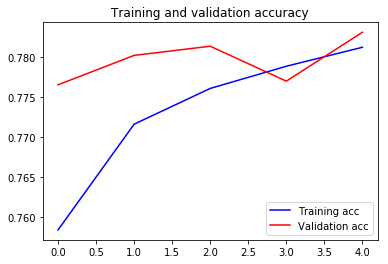

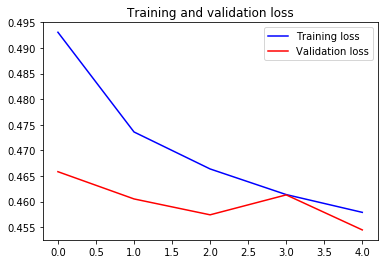

In [16]:
# Evaluation
import matplotlib.pyplot as plt
X_test_padded = tokenizer.texts_to_sequences(X_test.text)
X_test_padded = pad_sequences(X_test_padded, maxlen=MAX_SEQUENCE_LENGTH)
score = model.evaluate(X_test_padded, y_test, batch_size=512)
print("ACCURACY:",score[1])
print("LOSS:",score[0])

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [17]:
model.save('/kaggle/working/Sentiment_CNN_model.h5')

In [18]:
def predict(text, include_neutral=True):
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=MAX_SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    return {"score": float(score)}  



predict("@Nintendo I love your games!")

{'score': 0.8253055810928345}